<a href="https://colab.research.google.com/github/manishrawat2022/ReStock/blob/main/Final_Text_Processing_Mapping_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Importing all required libraries

import pandas as pd
import numpy as np

import re
import sys

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from tensorflow.keras.models import save_model

In [ ]:
# Requirements for nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

# Read Data

In [ ]:
#path = "/content/drive/MyDrive/Capstone_Project/Data"

#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/data_nse_1.csv')
#df_hdfc = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/HDFCBANK.csv')
#df_mm = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/M&M.csv')
#df_mc = pd.read_csv('/content/Data_mc_v2.csv')
#df_nse = pd.read_csv('/content/data_nse_1.csv')

#df_mc = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Data_mc_v4.csv')
#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/nse_data/HDFCBANK.csv')

#df_mc = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/moneycontrol_data/Data_mc_v6.csv')
df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/nse_data/M&M.csv')
#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/SBIN.csv')
# Dataset is now stored in a Pandas Dataframe

df_mc = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/moneycontrol_data/Data_mc_v6.csv')
#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/nse_data/SBIN.csv')
#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/nse_data/nifty_bank.csv')
#df_nse = pd.read_csv('/content/drive/MyDrive/Capstone_Project/Data/Final/nse_data/nifty50.csv')


# Text Cleaning Function

In [ ]:
# replace punctuations with space
def remove_punc(text):
  return re.sub('[^a-zA-Z]',' ', str(text))

# lower case
def lower_case(text):
  return text.lower()

# Remove tags
def remove_tags(text):
  return re.sub("&lt;/?.*?&gt;","&lt;&gt; ", text)

# Remove special characters and digits
def remove_special_chars_and_digits(text):
  return re.sub("(\\d|\\W)+"," ", text)

# Create tokens
def run_nltk_tokenizer(text):
  tokens = nltk.word_tokenize(text)
  return tokens

# Remove stop words
def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))-set(['no','not'])
  word_tokens =run_nltk_tokenizer(text)
  filtered_sentence = []
  for w in word_tokens:
    if w not in stop_words:
      filtered_sentence.append(w)
  return filtered_sentence

# Perform lemmatization
def apply_lemmatization(wlist):
  lem= WordNetLemmatizer()
  output = ' '.join([lem.lemmatize(w) for w in wlist])
  return output

# Full Cleaning text
def normalize(text):
  text = remove_punc(text)
  text = lower_case(text)
  text = remove_tags(text)
  text = remove_special_chars_and_digits(text)
  text = remove_stop_words(text)
  text = apply_lemmatization(text)
  return text

# Date Selection for data

In [ ]:
# Select dates for which news is present
start = min(df_mc.Date)
end = max(df_mc.Date)

In [ ]:
# Select Dates
df1 = df_nse[(df_nse.Date>=start)& (df_nse.Date<=end)]

# Text Processing

In [ ]:
df_mc['cleaned_title']=df_mc['title'].apply(normalize)

In [ ]:
df_mc['cleaned_desc']=df_mc['desc'].apply(normalize)

In [ ]:
df_mc['cleaned_content']=df_mc['content'].apply(normalize)

# Group df_mc by date

In [ ]:
# Grouping by date to bring all news items as per date
a=df_mc.astype({"desc": str, "content": str}).groupby('Date', as_index = False) # Removes null values in content column
A=a.agg({'cleaned_title': ' '.join,
       'cleaned_desc': ' '.join,
      'cleaned_content': ' '.join})

In [ ]:
B=A.copy()

In [ ]:
# Selecting news data as per avaialble stock data
C=A[A.Date<=max(df_nse.Date)]

In [ ]:
# Outer join of hdfc data and moneycontrol news data
join1=pd.merge(left=df1, right=C, on= 'Date', how='outer')#.to_csv('hdfcmergeouter_samedates.csv')#join1=

# Joining datasets

In [ ]:
# sort by date
join2=join1.sort_values(by=['Date'],ignore_index=True )

In [ ]:
# Where closing price is null (Sat,Sun, Holidays) replace date by null
cond = join2["Close"].isnull()
join2.loc[cond, "Date"] = np.nan

In [ ]:
# Forward fill null dates with previous value
join2["Date"].ffill(inplace=True)

In [ ]:
join3 = join2.copy()

In [ ]:
# Grouping by date again to join remaining text data, and taking relevant variables
join4 = join3.groupby('Date', as_index = False).agg({'cleaned_title': ' '.join,
                                             'cleaned_desc': ' '.join,
                                              'cleaned_content': ' '.join,
                                            #  'Prev Close':sum,
                                              'Open': sum,
                                              'High':sum,
                                              'Low':sum,
                                              'Close':sum,
                                              'Volume':sum
                                               })

# Dataset creation

In [ ]:
dataset = join4.copy()

In [ ]:
# adding percentage change feature
change = []

for i in range(len(dataset['Close'])) :
  if i==0:      # return zero for first value
    temp = 0
  else:
    temp = (dataset['Close'].iloc[i]- dataset['Close'].iloc[(i-1)])*100/dataset['Close'].iloc[(i-1)]
  
  change.append(round(temp,2))


#dataset['percent_change'] = (dataset['Close']- dataset['Prev Close'])/dataset['Prev Close']

dataset['percent_change'] = np.array(change)

In [ ]:
def sentiment(value): 
  if value>0:
    return 'positive'
  elif value<0:
    return 'negative'
  else:
    return 'neutral'

In [ ]:
dataset['sentiment']= dataset['percent_change'].apply(sentiment)

In [ ]:
# Final dataset
#sym = df_nse.Symbol[0]
sym = 'M&M'
dataset.to_csv(f'dataset_{sym}.csv',index=False)

# EDA

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
portfolio = ['auto', 'bank', 'oil', 'pharmaceutical', 'cement', 'technology']

## TF-IDF Experiment

In [ ]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    stop_words = 'english')

In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words = set(nltk.corpus.stopwords.words('english')))

In [ ]:
vectorizer_tfidf

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [ ]:
tfidf_scores_content3 = vectorizer_tfidf.fit_transform(dataset.cleaned_title)

In [ ]:
# Create Data Frame of tdief scores
tfidf_df_content3 = pd.DataFrame(tfidf_scores_content3.toarray(),
             columns = vectorizer_tfidf.get_feature_names_out(),
             index = dataset.index)

In [ ]:
tfidf_scores_content3.shape

(114, 6405)

In [ ]:
# Extract tfidf scores for portfolio
tfidf_df_content3[portfolio]

,auto,bank,oil,pharmaceutical,cement,technology
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...
109,0.005375,0.008615,0.006531,0.0,0.005927,0.009702
110,0.000000,0.000000,0.029543,0.0,0.000000,0.000000
111,0.000000,0.019908,0.000000,0.0,0.000000,0.000000
112,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [ ]:
# calculate average tfidf scores for portfolio
tfidf_df_content3[portfolio].mean()

auto              0.010403
bank              0.035681
oil               0.017770
pharmaceutical    0.006037
cement            0.007664
technology        0.010729
dtype: float64

In [ ]:
# Calculate tfidf for all columns and list top 10
tfidf_df_content3.mean().sort_values(ascending = False).head(10)

target    0.083039
buy       0.065265
india     0.064205
fund      0.047540
crore     0.046895
stock     0.038188
sale      0.037804
june      0.036982
net       0.036570
bank      0.035681
dtype: float64

## Word2vec

In [ ]:
dfw = (dataset.copy().loc[:,['cleaned_title']])

In [ ]:
dfw

,cleaned_title
0,life insurance claim would valid case death du...
1,woman manage money well men step peculiar mone...
2,sell equity buy gold instead amfi see uptick f...
3,planning summer holiday five co branded airlin...
4,explained crypto taxation work india hypertens...
...,...
109,government privatisation push danger delayed n...
110,sound exit strategy crucial enjoying benefit g...
111,cloud hang u chipmakers worry data center grow...
112,urge caution dog catch monkeypox canadian lawm...


In [ ]:
dfw['token'] = dfw['cleaned_title'].apply(lambda x : nltk.word_tokenize(x))

In [ ]:
dfw

,cleaned_title,token
0,life insurance claim would valid case death du...,"[life, insurance, claim, would, valid, case, d..."
1,woman manage money well men step peculiar mone...,"[woman, manage, money, well, men, step, peculi..."
2,sell equity buy gold instead amfi see uptick f...,"[sell, equity, buy, gold, instead, amfi, see, ..."
3,planning summer holiday five co branded airlin...,"[planning, summer, holiday, five, co, branded,..."
4,explained crypto taxation work india hypertens...,"[explained, crypto, taxation, work, india, hyp..."
...,...,...
109,government privatisation push danger delayed n...,"[government, privatisation, push, danger, dela..."
110,sound exit strategy crucial enjoying benefit g...,"[sound, exit, strategy, crucial, enjoying, ben..."
111,cloud hang u chipmakers worry data center grow...,"[cloud, hang, u, chipmakers, worry, data, cent..."
112,urge caution dog catch monkeypox canadian lawm...,"[urge, caution, dog, catch, monkeypox, canadia..."


In [ ]:
# take a subset of 200 tokens here. These 200 may be ‘random’ or top 200 tokens with the highest tf-idf scores.
top200_tokens_tfidf_3 = (tfidf_df_content3.mean()
                                          .sort_values(ascending=False)
                                          .head(200)
                                          .index)
# For content3 with embedding size to be 200
model31_word2vec = Word2Vec(sentences=dfw.token,
                          size=200,  #Embedding size = 200 --> Change as per the need  
                          min_count=1)
top200_tokens_tfidf_vectors = {token: model31_word2vec.wv[token] 
                               for token in top200_tokens_tfidf_3}
top200_tfidf_word_vectors_m31 = (pd.DataFrame(top200_tokens_tfidf_vectors)
                               .transpose())
top200_tfidf_word_vectors_m31

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
target,0.067518,0.201276,0.144600,-0.013969,0.058717,0.408406,-0.062683,-0.343720,0.087485,-0.206828,...,-0.364414,-0.118781,-0.086452,0.155029,-0.253664,-0.325830,-0.345864,0.042070,0.167252,-0.192305
buy,0.067884,0.194850,0.142107,-0.014925,0.060179,0.388128,-0.056811,-0.325659,0.083014,-0.197664,...,-0.348462,-0.117101,-0.086618,0.140595,-0.241135,-0.305524,-0.326769,0.040391,0.157461,-0.183679
india,0.153987,0.386924,0.275759,-0.050868,0.107204,0.728559,-0.112786,-0.596433,0.189472,-0.385364,...,-0.678734,-0.213248,-0.187920,0.260907,-0.466372,-0.580849,-0.630422,0.063890,0.328146,-0.338723
fund,0.130589,0.314150,0.228143,-0.044307,0.088675,0.590402,-0.088133,-0.482999,0.155527,-0.310023,...,-0.546439,-0.169233,-0.154092,0.213105,-0.379604,-0.473309,-0.511723,0.043974,0.265364,-0.272219
crore,0.032462,0.089573,0.073492,-0.116426,0.041117,0.154782,-0.060181,-0.139840,0.106814,-0.060907,...,-0.127108,-0.089325,-0.015249,0.029024,-0.109198,-0.160313,-0.186789,0.038555,0.055492,-0.044386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
delivered,0.004946,0.010513,0.007837,-0.000325,0.002516,0.019393,-0.005186,-0.018763,0.004554,-0.008373,...,-0.018748,-0.004836,-0.005743,0.006240,-0.012091,-0.014478,-0.018600,0.001918,0.011760,-0.011638
step,0.029145,0.069630,0.048682,-0.010690,0.019121,0.133641,-0.018305,-0.107903,0.032566,-0.068308,...,-0.123614,-0.041329,-0.031815,0.045945,-0.084175,-0.106260,-0.113379,0.013266,0.057574,-0.061825
join,0.034969,0.077054,0.055604,-0.012598,0.023451,0.151314,-0.022183,-0.123187,0.038124,-0.077354,...,-0.139402,-0.042226,-0.038118,0.051097,-0.094634,-0.120807,-0.127504,0.012198,0.067113,-0.068755
crisis,0.032029,0.081112,0.056104,-0.009450,0.020813,0.151040,-0.024153,-0.123434,0.038285,-0.082753,...,-0.142783,-0.045582,-0.042247,0.053864,-0.095534,-0.121684,-0.134037,0.010573,0.067143,-0.070058


In [ ]:
# Computing the similarities for 
similarities = cosine_similarity(top200_tfidf_word_vectors_m31, 
                                 top200_tfidf_word_vectors_m31)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

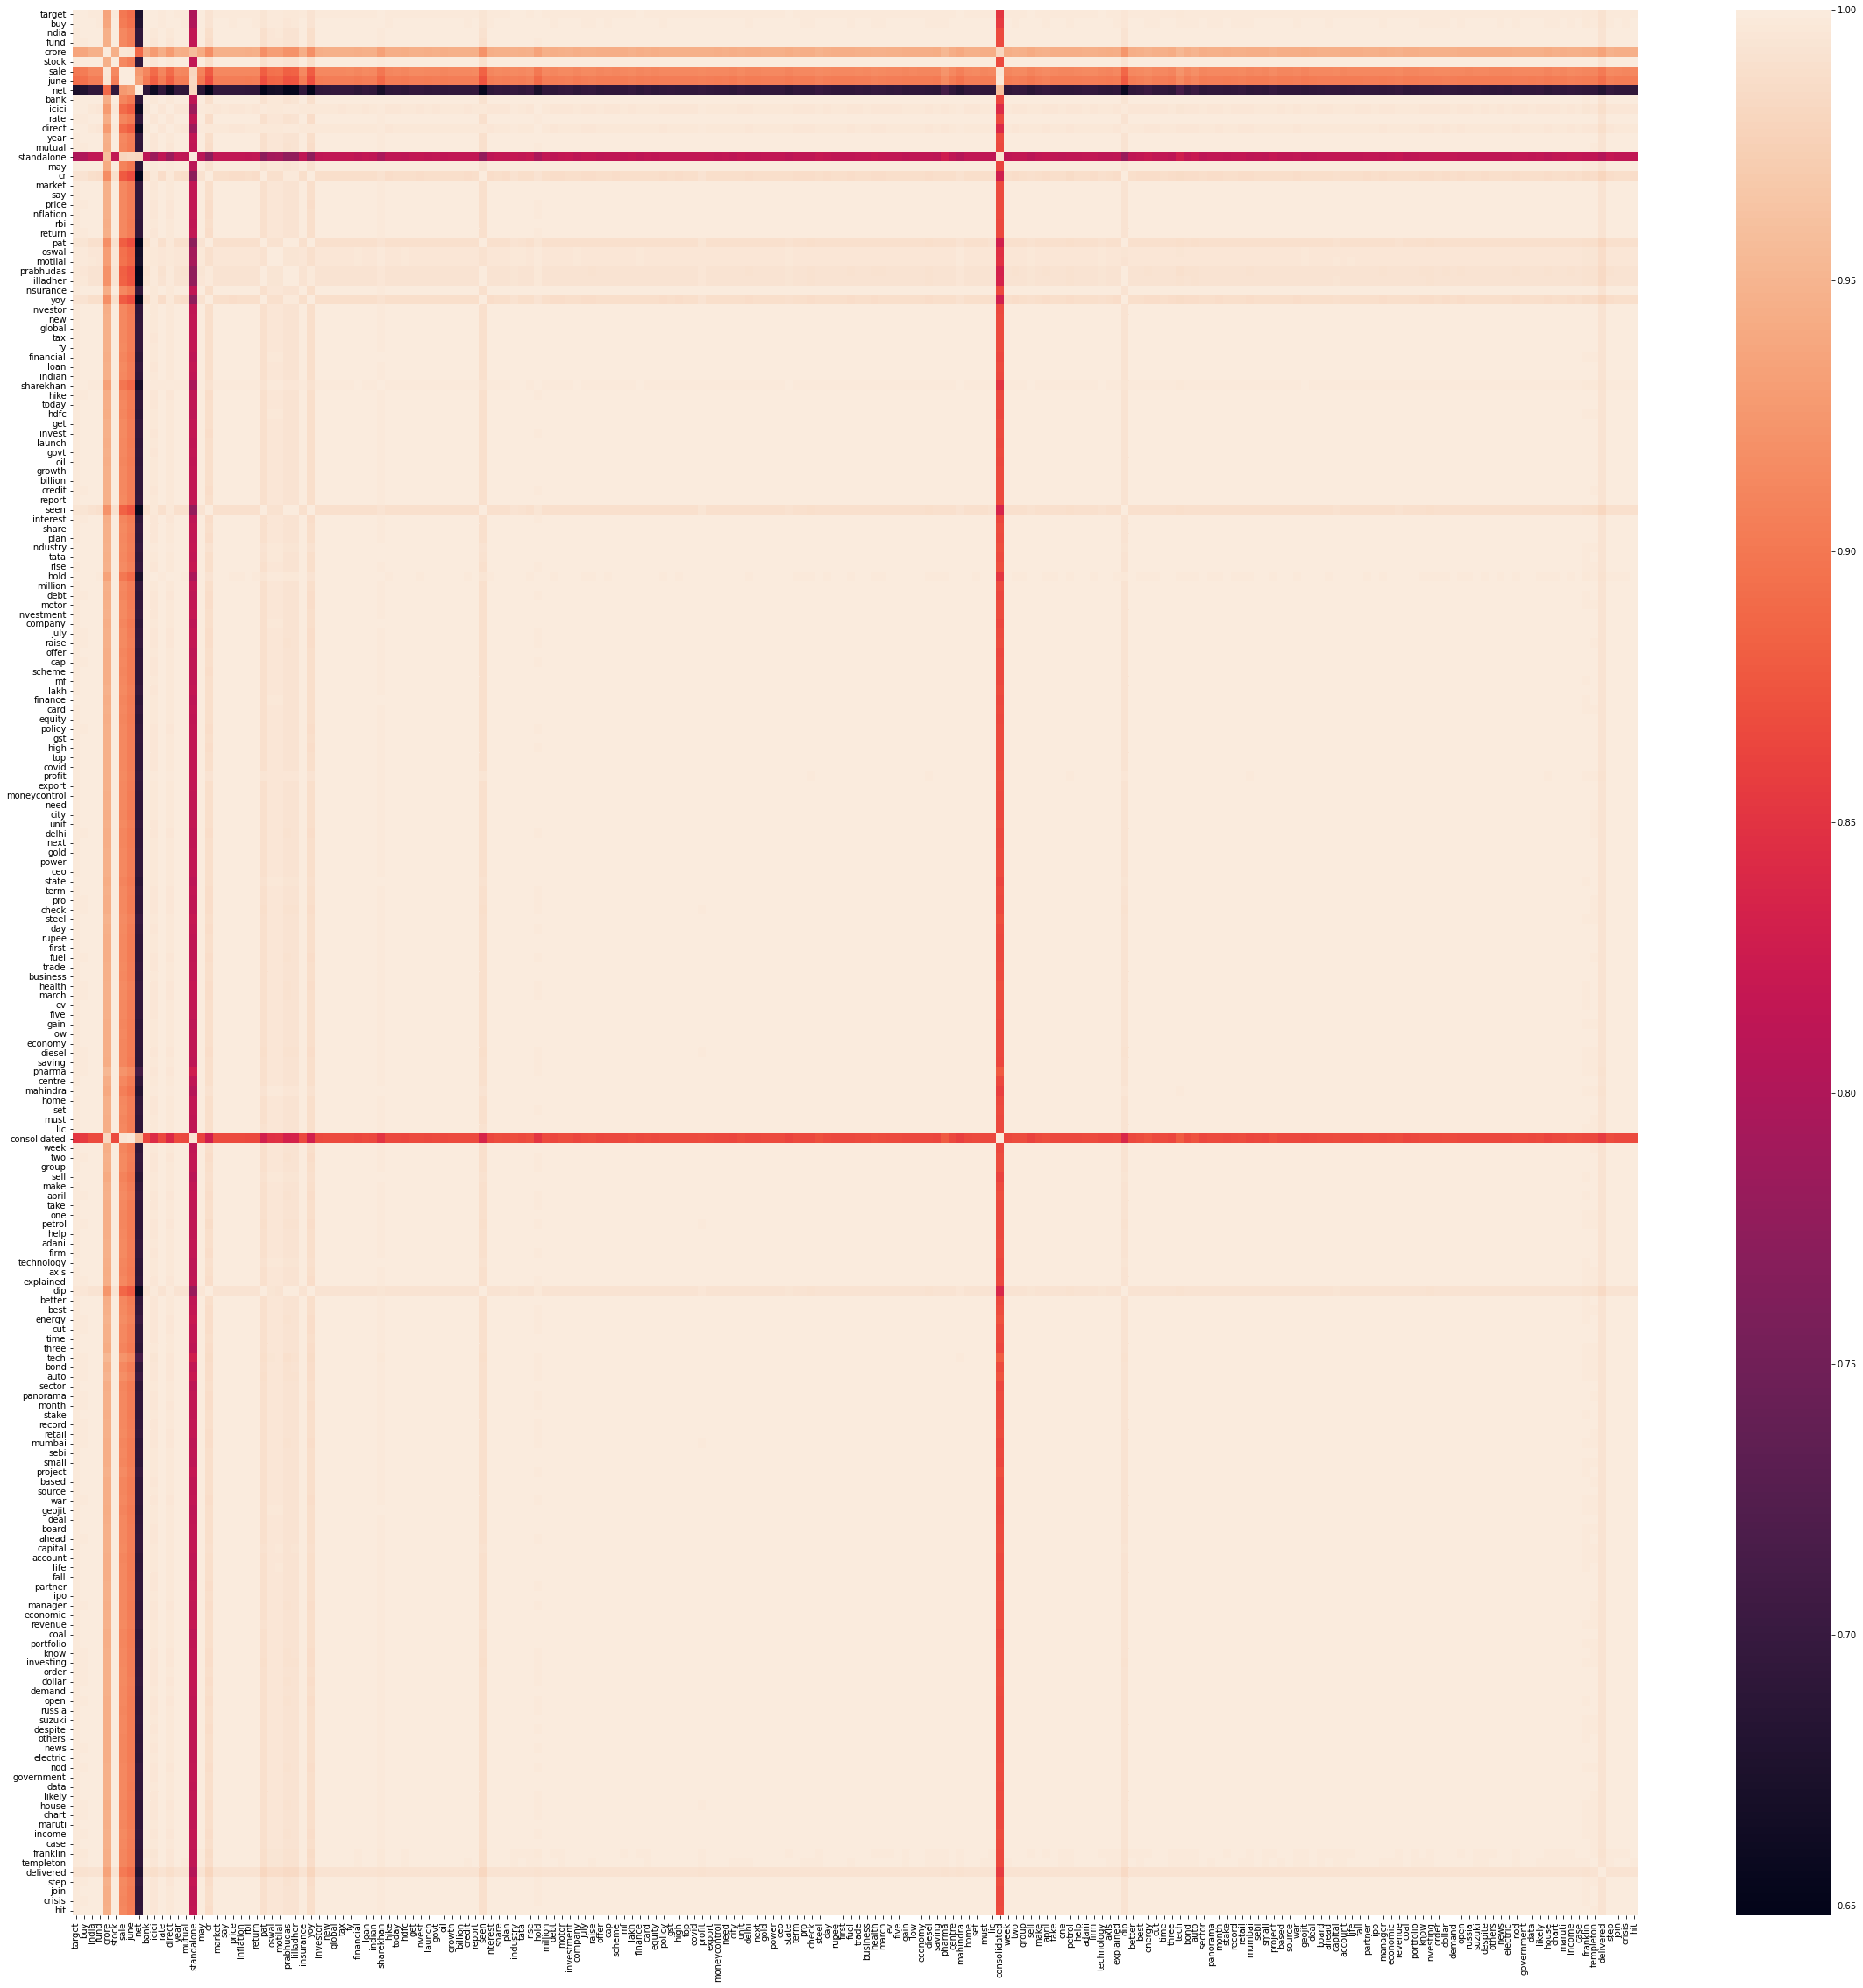

In [ ]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=top200_tfidf_word_vectors_m31.index, 
            yticklabels=top200_tfidf_word_vectors_m31.index)

## Doc2Vec

In [ ]:
dfw.head(1)

,cleaned_title,token
0,life insurance claim would valid case death du...,"[life, insurance, claim, would, valid, case, d..."


In [ ]:
review_token3 = dfw['token']

In [ ]:
review_token3

0      [life, insurance, claim, would, valid, case, d...
1      [woman, manage, money, well, men, step, peculi...
2      [sell, equity, buy, gold, instead, amfi, see, ...
3      [planning, summer, holiday, five, co, branded,...
4      [explained, crypto, taxation, work, india, hyp...
                             ...                        
109    [government, privatisation, push, danger, dela...
110    [sound, exit, strategy, crucial, enjoying, ben...
111    [cloud, hang, u, chipmakers, worry, data, cent...
112    [urge, caution, dog, catch, monkeypox, canadia...
113    [uk, spy, chief, jeremy, fleming, say, vladimi...
Name: token, Length: 114, dtype: object

In [ ]:
tagged_documents = [TaggedDocument(review_token, [i]) 
                    for i, review_token in enumerate(review_token3)]
tagged_documents[0]

TaggedDocument(words=['life', 'insurance', 'claim', 'would', 'valid', 'case', 'death', 'due', 'war', 'need', 'know', 'inflation', 'monster', 'eat', 'saving', 'antidote', 'investment', 'motherhood', 'ahead', 'plan', 'child', 'expense', 'build', 'kitty'], tags=[0])

In [ ]:
doc2vec_model = Doc2Vec(tagged_documents, 
                            vector_size=200, ##Embedding size 200 --> Change for other sizes
                            window=3, 
                            min_count=2) 

In [ ]:
doc2vec_df = pd.DataFrame()
for r in review_token3: 
    vector = pd.DataFrame(doc2vec_model.infer_vector(r)).transpose()
    doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)

doc2vec_df.index = dataset.index

In [ ]:
doc2vec_df.shape

(114, 200)

In [ ]:
doc2vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.017594,-0.005294,-0.006608,0.004841,-0.026089,0.011916,0.008776,-0.035574,-0.039391,-0.007637,...,-0.055861,-0.005728,-0.048134,0.003797,-0.060121,-0.038045,-0.006534,-0.047259,0.057582,0.024579
1,0.076060,-0.009795,-0.029642,0.018086,-0.095596,0.041171,0.030178,-0.150225,-0.157922,-0.020437,...,-0.216367,-0.031649,-0.188768,0.008171,-0.238690,-0.151208,-0.033269,-0.185156,0.231164,0.090674
2,0.017844,-0.001957,-0.007787,0.004061,-0.017806,0.010460,0.004259,-0.030559,-0.033421,-0.003371,...,-0.041540,-0.008518,-0.038096,0.001156,-0.049147,-0.032491,-0.008781,-0.037423,0.047016,0.021483
3,0.043750,-0.005633,-0.018292,0.010223,-0.050949,0.020619,0.017624,-0.080774,-0.085764,-0.011946,...,-0.118903,-0.017108,-0.105876,0.005192,-0.131539,-0.084520,-0.017527,-0.103808,0.129371,0.051151
4,0.031943,-0.002479,-0.011074,0.006859,-0.039522,0.016125,0.014497,-0.058053,-0.063446,-0.006020,...,-0.086172,-0.014486,-0.074374,0.005990,-0.094483,-0.060278,-0.013550,-0.073064,0.091344,0.035765


# Sentiment Analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
labels = np.where(dataset.sentiment == 'negative', 0, 1)

In [ ]:
dataset.sentiment.value_counts()

positive    68
negative    45
neutral      1
Name: sentiment, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(doc2vec_df, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

In [ ]:
X =pd.concat((X_train,X_test),axis=0)

## Random Forest

In [ ]:
model_RF = RandomForestClassifier()

In [ ]:
for C_value in [1, 100, 500, 1000, 5000, 10000]:
    model_RF = RandomForestClassifier(n_estimators=C_value)
    model_RF.fit(X_train, y_train)
    y_pred = model_RF.predict(X_test)
    acc = accuracy_score(y_test, y_pred) 
    print(f"C: {C_value}, Accuracy: {acc}")

C: 1, Accuracy: 0.47368421052631576
C: 100, Accuracy: 0.42105263157894735
C: 500, Accuracy: 0.47368421052631576
C: 1000, Accuracy: 0.4473684210526316
C: 5000, Accuracy: 0.47368421052631576
C: 10000, Accuracy: 0.4473684210526316


In [ ]:
model_RF = RandomForestClassifier(n_estimators=5000)
model_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000)

In [ ]:
model_RF.predict(X_test)

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
rf_score = model_RF.predict_proba(X)[:,1]

In [ ]:
rf_score

array([0.9544, 0.954 , 0.9278, 0.8618, 0.893 , 0.195 , 0.834 , 0.9544,
       0.9456, 0.8094, 0.8882, 0.7488, 0.3296, 0.7576, 0.7646, 0.3446,
       0.729 , 0.3196, 0.2946, 0.7118, 0.783 , 0.7368, 0.2618, 0.8948,
       0.9746, 0.721 , 0.162 , 0.2   , 0.8176, 0.8772, 0.9324, 0.2732,
       0.9272, 0.9378, 0.2542, 0.9596, 0.1272, 0.903 , 0.1318, 0.139 ,
       0.807 , 0.3152, 0.7132, 0.1346, 0.7754, 0.1206, 0.9426, 0.1518,
       0.8206, 0.1798, 0.2332, 0.928 , 0.6906, 0.9106, 0.3364, 0.898 ,
       0.6838, 0.2722, 0.9776, 0.8616, 0.8484, 0.9486, 0.2548, 0.3018,
       0.753 , 0.1478, 0.2336, 0.8938, 0.204 , 0.1268, 0.7562, 0.9306,
       0.8822, 0.8508, 0.1492, 0.152 , 0.9348, 0.6284, 0.4698, 0.3614,
       0.243 , 0.3842, 0.8698, 0.4886, 0.7836, 0.8184, 0.8382, 0.4936,
       0.4368, 0.8858, 0.5934, 0.5318, 0.6972, 0.478 , 0.4514, 0.3702,
       0.9246, 0.491 , 0.6128, 0.8204, 0.8302, 0.7192, 0.3474, 0.7968,
       0.855 , 0.6002, 0.5562, 0.4264, 0.4704, 0.6816, 0.7928, 0.8522,
      

In [ ]:
pd.DataFrame(np.array(rf_score)).to_csv('M&M_rf_score.csv',index=False)

In [ ]:
print(classification_report(y_test, model_RF.predict(X_test)))
#print(classification_report(y_test, model_RF.predict(X_test)))

              precision    recall  f1-score   support

           0       0.33      0.31      0.32        16
           1       0.52      0.55      0.53        22

    accuracy                           0.45        38
   macro avg       0.43      0.43      0.43        38
weighted avg       0.44      0.45      0.44        38

